In [7]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


testing 

FASTA ID示例: ['lcl|NM_001410800.1_cds_NP_001397729.1_1', 'lcl|NM_001282630.3_cds_NP_001269559.1_1']

预测文件中的ID示例:
lcl|NM_001410800.1_cds_NP_001397729.1_1 [gene=C...
lcl|NM_001282630.3_cds_NP_001269559.1_1 [gene=P...
lcl|NM_015302.2_cds_NP_056117.1_1 [gene=HAUS5] ...

Classification Report:
              precision    recall  f1-score   support

    Negative       0.17      0.80      0.28         5
       Virus       0.93      0.41      0.57        34

    accuracy                           0.46        39
   macro avg       0.55      0.61      0.42        39
weighted avg       0.84      0.46      0.53        39



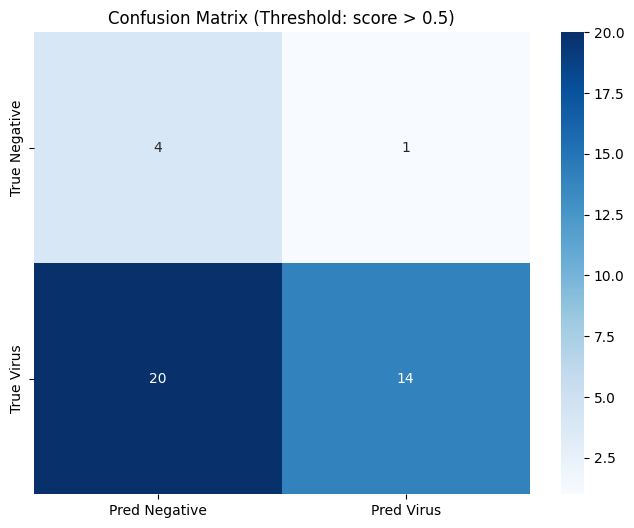

In [11]:
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 配置参数
FASTA_FILE = "testing_data/testing_sequence.fasta"
DEEPVIR_RESULT = "testing_data/testing_sequence.fasta_gt1bp_dvfpred.txt"
NEGATIVE_IDS = [
    "lcl|NM_001410800.1_cds_NP_001397729.1_1",
    "lcl|NM_015302.2_cds_NP_056117.1_1",  
    "lcl|NM_001201575.2_cds_NP_001188504.1_1",
    "lcl|NM_001282308.2_cds_NP_001269237.1_1",
    "lcl|NM_001282630.3_cds_NP_001269559.1_1"   
]

def get_all_ids(fasta_file):
    # 精确提取ID（去除注释）
    return [record.description.split()[0] for record in SeqIO.parse(fasta_file, "fasta")]

def create_true_labels(all_ids, negative_ids):
    return {seq_id: 0 if seq_id in negative_ids else 1 for seq_id in all_ids}

def load_deepvir_predictions(result_file):
    try:
        # 强制使用制表符分隔，指定列名
        df = pd.read_csv(result_file, sep="\t", header=0,
                        names=["name", "len", "score", "pvalue"])
        
        print("\n预测文件中的ID示例:")
        print(df["name"].head(3).to_string(index=False))
        
        # 去除预测ID中的可能空格
        df["name"] = df["name"].str.split().str[0]
        
        df["pred_label"] = (df["score"] > 0.5).astype(int)
        return df.set_index("name")["pred_label"].to_dict()
    except Exception as e:
        print(f"Error: {str(e)}")
        return {}

def evaluate_performance(true_labels, pred_labels):
    y_true = [true_labels[seq_id] for seq_id in true_labels]
    y_pred = [pred_labels.get(seq_id, 0) for seq_id in true_labels]
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                               target_names=["Negative", "Virus"],
                               zero_division=0))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred Negative", "Pred Virus"],
                yticklabels=["True Negative", "True Virus"])
    plt.title("Confusion Matrix (Threshold: score > 0.5)")
    plt.show()

if __name__ == "__main__":
    # 获取并清洗ID
    all_ids = get_all_ids(FASTA_FILE)
    print(f"FASTA ID示例: {all_ids[:2]}")
    
    # 创建标签
    true_labels = create_true_labels(all_ids, NEGATIVE_IDS)
    
    # 加载预测结果
    pred_labels = load_deepvir_predictions(DEEPVIR_RESULT)
    
    if pred_labels:
        evaluate_performance(true_labels, pred_labels)
        
        # 检查未匹配项
        missing = set(all_ids) - set(pred_labels.keys())
        if missing:
            print(f"\n未匹配ID示例:")
            for m in list(missing)[:3]:
                print(f"FASTA ID: {m}")
                print(f"预测文件中是否存在: {m in df['name'].values}\n")
    else:
        print("预测结果加载失败")

Loaded 39 sequences from FASTA
True labels: 5 Negative, 34 Virus

Classification Report:
              precision    recall  f1-score   support

    Negative       0.17      1.00      0.29         5
       Virus       1.00      0.26      0.42        34

    accuracy                           0.36        39
   macro avg       0.58      0.63      0.35        39
weighted avg       0.89      0.36      0.40        39



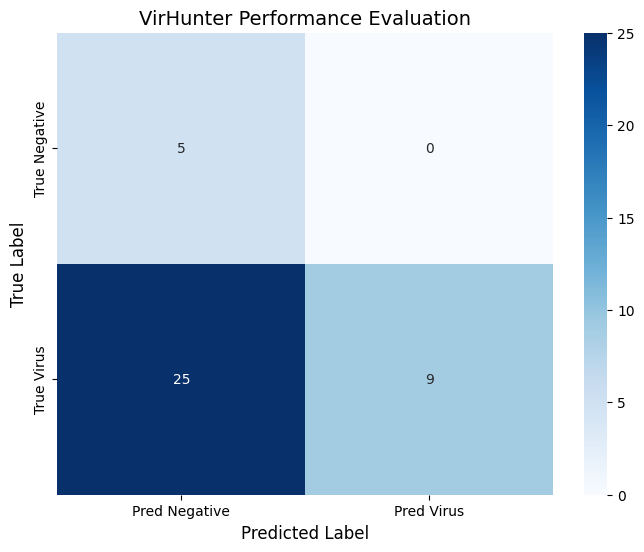

In [13]:
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 配置参数
FASTA_FILE = "testing_data/testing_sequence.fasta"  # FASTA文件路径
VIRHUNTER_RESULT = "virhunter_data/output/testing_sequence_predicted.csv"      # VirHunter结果文件路径
NEGATIVE_IDS = [                                    # 已知负样本ID列表
    "lcl|NM_001410800.1_cds_NP_001397729.1_1",
    "lcl|NM_015302.2_cds_NP_056117.1_1",  
    "lcl|NM_001201575.2_cds_NP_001188504.1_1",
    "lcl|NM_001282308.2_cds_NP_001269237.1_1",
    "lcl|NM_001282630.3_cds_NP_001269559.1_1"   
]

def get_fasta_ids(fasta_file):
    """从FASTA文件中提取所有序列ID（去除注释部分）"""
    return [record.description.split()[0] for record in SeqIO.parse(fasta_file, "fasta")]

def create_true_labels(all_ids, negative_ids):
    """根据负样本ID列表生成真实标签字典"""
    return {seq_id: 0 if seq_id in negative_ids else 1 for seq_id in all_ids}

def load_virhunter_predictions(result_file):
    """加载VirHunter预测结果"""
    try:
        df = pd.read_csv(result_file)
        
        # 规范化列名（兼容大小写和空格）
        df.columns = [col.strip().lower() for col in df.columns]
        
        # 关键列检查
        required_columns = ["id", "decision"]
        if not set(required_columns).issubset(df.columns):
            raise ValueError(f"Missing required columns. Current columns: {df.columns.tolist()}")
        
        # 创建预测标签字典（virus=1, plant=0）
        df["pred_label"] = df["decision"].str.lower().map({"virus": 1, "plant": 0})
        return df.set_index("id")["pred_label"].to_dict()
    except Exception as e:
        print(f"Error loading VirHunter results: {str(e)}")
        return {}

def evaluate_performance(true_labels, pred_labels):
    """评估模型性能"""
    # 对齐标签
    y_true = []
    y_pred = []
    for seq_id, true_label in true_labels.items():
        y_true.append(true_label)
        y_pred.append(pred_labels.get(seq_id, 0))  # 未匹配的序列默认预测为Negative
        
    # 生成分类报告
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                               target_names=["Negative", "Virus"],
                               zero_division=0))
    
    # 绘制混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred Negative", "Pred Virus"],
                yticklabels=["True Negative", "True Virus"])
    plt.ylabel("True Label", fontsize=12)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.title("VirHunter Performance Evaluation", fontsize=14)
    plt.show()

def main():
    # 获取所有FASTA ID
    try:
        all_ids = get_fasta_ids(FASTA_FILE)
        print(f"Loaded {len(all_ids)} sequences from FASTA")
    except FileNotFoundError:
        print(f"Error: FASTA file not found at {FASTA_FILE}")
        return
    
    # 创建真实标签
    true_labels = create_true_labels(all_ids, NEGATIVE_IDS)
    num_negative = sum(v == 0 for v in true_labels.values())
    num_virus = sum(v == 1 for v in true_labels.values())
    print(f"True labels: {num_negative} Negative, {num_virus} Virus")
    
    # 加载预测结果
    pred_labels = load_virhunter_predictions(VIRHUNTER_RESULT)
    if not pred_labels:
        return
    
    # 检查ID匹配情况
    missing = set(all_ids) - set(pred_labels.keys())
    if missing:
        print(f"\nWarning: {len(missing)} sequences missing in predictions (examples):")
        print("\n".join(list(missing)[:3]))
    
    # 评估性能
    evaluate_performance(true_labels, pred_labels)

if __name__ == "__main__":
    main()

正在处理数据...

加载测试数据:
发现 2 条重复序列，已去重

加载VirNatrap预测结果:

匹配统计:
_merge
left_only     35
both           2
right_only     0

分类性能报告:
              precision    recall  f1-score   support

    Negative       0.14      1.00      0.25         5
       Virus       1.00      0.06      0.12        32

    accuracy                           0.19        37
   macro avg       0.57      0.53      0.18        37
weighted avg       0.88      0.19      0.14        37


完整报告已保存至 full_analysis_report.csv

未预测序列已保存至 unpredicted_sequences/missing_sequences.fasta（已格式化换行）


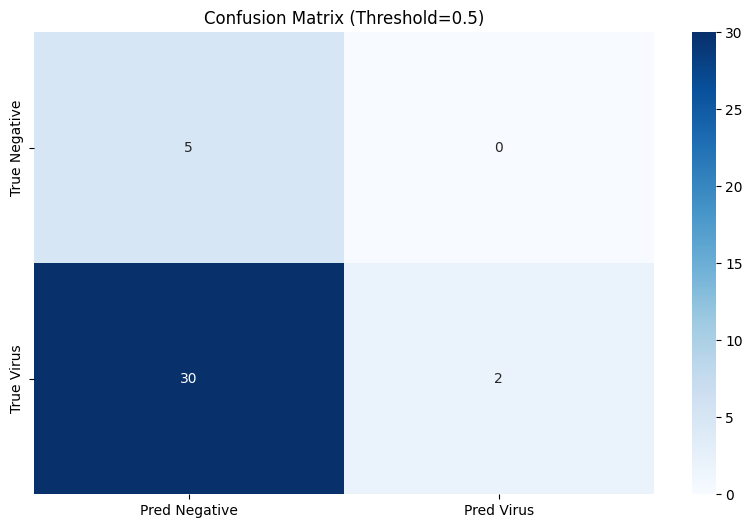

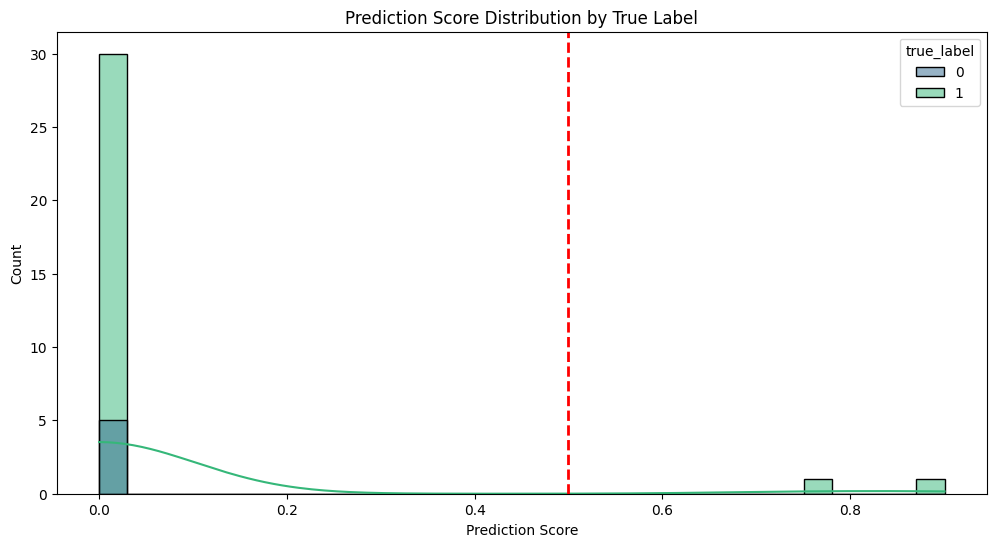

In [19]:
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import sys
import os

# ======================
# 配置参数
# ======================
TESTING_FASTA = "testing_data/testing_sequence.fasta"  # 原始测试数据路径
VIRNATRAP_OUTPUT = "virnatrap/output_contigs/testing_sequence.txt"  # VirNatrap输出路径
NEGATIVE_IDS = [
    "lcl|NM_001410800.1_cds_NP_001397729.1_1",
    "lcl|NM_015302.2_cds_NP_056117.1_1",
    "lcl|NM_001201575.2_cds_NP_001188504.1_1",
    "lcl|NM_001282308.2_cds_NP_001269237.1_1",
    "lcl|NM_001282630.3_cds_NP_001269559.1_1"
]
THRESHOLD = 0.5  # 分类阈值
SEQ_CLEAN_PARAMS = {   # 序列标准化参数
    "remove_chars": ["\n", "\r", "*", " ", "N", "."],  # 包含换行符处理
    "to_upper": True,
    "strip_whitespace": True
}

# ======================
# 核心函数
# ======================
def clean_sequence(seq, params):
    """深度清洗序列"""
    # 去除指定字符
    if "remove_chars" in params:
        for char in params["remove_chars"]:
            seq = seq.replace(char, "")
    
    # 转换大写
    if params.get("to_upper", False):
        seq = seq.upper()
    
    # 去除首尾空白
    if params.get("strip_whitespace", False):
        seq = seq.strip()
    
    return seq

def load_processed_fasta(file_path, is_pred=False):
    """加载并处理FASTA文件"""
    try:
        records = []
        for record in SeqIO.parse(file_path, "fasta"):
            # 处理原始序列
            raw_seq = str(record.seq)
            clean_seq = clean_sequence(raw_seq, SEQ_CLEAN_PARAMS)
            
            # 构建记录
            rec = {
                "original_id": record.description.split()[0],
                "raw_length": len(raw_seq),
                "clean_sequence": clean_seq,
                "clean_length": len(clean_seq)
            }
            
            # 解析预测分数
            if is_pred:
                header = record.description
                if "[" in header and "]" in header:
                    rec["pred_score"] = float(header.split("[")[1].split("]")[0])
                else:
                    rec["pred_score"] = 0.0
                    print(f"警告：异常头部格式 - {header[:50]}...")
            
            records.append(rec)
        
        df = pd.DataFrame(records)
        
        # 数据验证
        if df.empty:
            raise ValueError("FASTA文件为空")
            
        # 检查序列唯一性
        dup_seq = df.duplicated("clean_sequence").sum()
        if dup_seq > 0:
            print(f"发现 {dup_seq} 条重复序列，已去重")
            df = df.drop_duplicates("clean_sequence")
        
        return df
    
    except FileNotFoundError:
        print(f"错误：文件 {file_path} 不存在")
        sys.exit(1)
    except Exception as e:
        print(f"处理文件时出错：{str(e)}")
        sys.exit(1)

# ======================
# 分析报告生成
# ======================
def generate_analysis_report(test_df, pred_df):
    """生成完整分析报告"""
    # 合并数据
    merged_df = pd.merge(
        test_df,
        pred_df[["clean_sequence", "pred_score"]],
        on="clean_sequence",
        how="left",
        indicator=True
    ).fillna({"pred_score": 0.0})
    
    # 添加预测标签
    merged_df["pred_label"] = (merged_df["pred_score"] > THRESHOLD).astype(int)
    
    # 打印合并结果
    print("\n" + "="*50)
    print(f"匹配统计:")
    print(merged_df["_merge"].value_counts().to_string())
    print("="*50 + "\n")
    
    # 分类报告
    print("分类性能报告:")
    print(classification_report(
        merged_df["true_label"],
        merged_df["pred_label"],
        target_names=["Negative", "Virus"],
        zero_division=0
    ))
    
    # 混淆矩阵
    plt.figure(figsize=(10, 6))
    cm = confusion_matrix(merged_df["true_label"], merged_df["pred_label"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred Negative", "Pred Virus"],
                yticklabels=["True Negative", "True Virus"])
    plt.title(f"Confusion Matrix (Threshold={THRESHOLD})")
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
    
    # 分数分布图
    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=merged_df,
        x="pred_score",
        hue="true_label",
        bins=30,
        kde=True,
        palette="viridis",
        edgecolor="black"
    )
    plt.axvline(THRESHOLD, color='red', linestyle='--', linewidth=2)
    plt.title("Prediction Score Distribution by True Label")
    plt.xlabel("Prediction Score")
    plt.ylabel("Count")
    plt.savefig("score_distribution.png", dpi=300, bbox_inches='tight')
    
    # 保存完整报告
    merged_df.to_csv("full_analysis_report.csv", index=False)
    print("\n完整报告已保存至 full_analysis_report.csv")
    
    return merged_df

# ======================
# 主程序
# ======================
def main():
    print("正在处理数据...")
    
    # 加载测试数据
    print("\n加载测试数据:")
    test_df = load_processed_fasta(TESTING_FASTA)
    test_df["true_label"] = test_df["original_id"].apply(
        lambda x: 0 if x in NEGATIVE_IDS else 1
    )
    
    # 验证负样本
    missing_neg = set(NEGATIVE_IDS) - set(test_df.original_id)
    if missing_neg:
        print(f"\n[警告] 缺失 {len(missing_neg)} 个负样本ID:")
        print("\n".join(list(missing_neg)[:3]))
    
    # 加载预测结果
    print("\n加载VirNatrap预测结果:")
    pred_df = load_processed_fasta(VIRNATRAP_OUTPUT, is_pred=True)
    
    # 生成报告
    merged_df = generate_analysis_report(test_df, pred_df)
    
    # 导出未匹配序列
    unpredicted = merged_df[merged_df["_merge"] == "left_only"]
    if not unpredicted.empty:
        os.makedirs("unpredicted_sequences", exist_ok=True)
        output_path = "unpredicted_sequences/missing_sequences.fasta"
        
        with open(output_path, "w") as f:
            for _, row in unpredicted.iterrows():
                seq = row["clean_sequence"]
                # 按70字符换行格式化
                formatted_seq = '\n'.join([seq[i:i+70] for i in range(0, len(seq), 70)])
                f.write(f">{row['original_id']}\n{formatted_seq}\n")
        
        print(f"\n未预测序列已保存至 {output_path}（已格式化换行）")

if __name__ == "__main__":
    main()